# Overview

This notebook documents the causal analysis conducted in this paper.

For reproducibility purposes, the packages that this running examples are:
- torch 2.4.0+cu121
- transformers 4.48.0
- datasets 3.1.0
- nnsight 0.3.6

While there are many alternative versions that might run the code, the exact versions of nnsight is recommended (or you might adapt more advanced nnsight operations into your own code).

In [1]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from utils import load_model, get_model_name, interpret_logits, get_probability_of_word
from transformers import AutoTokenizer, AutoModelForCausalLM 
import json 
clear_output()
class Args:
    model = "gemma"
args = Args()

device = torch.device("cuda:3")
model_names, num_layers = get_model_name(args)

model = LanguageModel(model_names, dispatch=True).to(device)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Below is a basic code snippet of how to obtain the top-k token visualizations following a prefix fed into the base model

In [2]:
prompt = "Joey Bosa is associated with the sport of"
tokenized_output = model.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        output = model.output.save()
outputs = output.value[0]
interpret_logits(model.tokenizer, logits=outputs[:, -1, :], top_k=10, get_proba=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


[(' football', 0.896),
 (' American', 0.031),
 (' Football', 0.01),
 (' college', 0.009),
 (' the', 0.006),
 (' professional', 0.005),
 (' soccer', 0.004),
 (' basketball', 0.003),
 (' baseball', 0.003),
 (' boxing', 0.002)]

For a more comprehensive coverage of intervention, please look at the `notebook/intervention.ipynb` file for references. Below is a simplified code snippet of doing model intervention.

In [6]:
# This is a playground for you; you may change the prompt or targeted intervention modules to get familiar with the code and nnsight framework
prompt = "The capital city of China is www. The capital city of China is"
tokenized_output = model.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

layer_num = 7
with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        clean_output = model.model.layers[layer_num].post_attention_layernorm.output.save()

clean_output = clean_output.value * 2

with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        model.model.layers[layer_num].post_attention_layernorm.output = clean_output 
        output = model.output.save()
outputs = output.value[0]
interpret_logits(model.tokenizer, logits=outputs[:,-1, :], top_k=10, get_proba=True)

[(' Beijing', 0.449),
 (' www', 0.211),
 (' the', 0.045),
 (' located', 0.034),
 (' a', 0.028),
 (' Shanghai', 0.018),
 (' ', 0.016),
 (' known', 0.011),
 (' also', 0.011),
 (' called', 0.01)]

# The Causal Experiment Part

In [7]:
import torch.distributions as dist
def calculate_entropy(raw_logit):
    prob_vec = torch.nn.functional.softmax(raw_logit, dim=-1)
    categorical = dist.Categorical(probs=prob_vec)
    return categorical.entropy()

def get_original_output_prob(
        model,
        prompt,
        target=" Paris"
):
    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            output = model.output.save()
    clean_output = output.value[0]
    logit = clean_output[:, -1, :]
    return get_probability_of_word(tokenizer=model.tokenizer, word=target, logit=logit, get_prob=True), calculate_entropy(logit).item()

def KnockOutEntireLayer(
        model, 
        prompt, 
        layer_num,
        target=" Paris"
):
    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            model.model.layers[layer_num].post_attention_layernorm.output = model.model.layers[layer_num].post_attention_layernorm.output * 0
            model.model.layers[layer_num].post_feedforward_layernorm.output = model.model.layers[layer_num].post_feedforward_layernorm.output * 0
            output = model.output.save()
    clean_output = output.value[0]
    logit = clean_output[:, -1, :]
    return get_probability_of_word(tokenizer=model.tokenizer, word=target, logit=logit, get_prob=True), calculate_entropy(logit).item()

def KnockOutMLP(
        model, 
        prompt, 
        layer_num,
        target=" Paris"
):
    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            model.model.layers[layer_num].post_feedforward_layernorm.output = model.model.layers[layer_num].post_feedforward_layernorm.output * 0
            output = model.output.save()
    clean_output = output.value[0]
    logit = clean_output[:, -1, :]
    return get_probability_of_word(tokenizer=model.tokenizer, word=target, logit=logit, get_prob=True), calculate_entropy(logit).item()

def KnockOutAttention(
        model, 
        prompt, 
        layer_num,
        target=" Paris"
):
    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            model.model.layers[layer_num].post_attention_layernorm.output = model.model.layers[layer_num].post_attention_layernorm.output * 0
            output = model.output.save()
    clean_output = output.value[0]
    logit = clean_output[:, -1, :]
    return get_probability_of_word(tokenizer=model.tokenizer, word=target, logit=logit, get_prob=True), calculate_entropy(logit).item()

In [8]:
KnockOutAttention(
    model=model, 
    prompt="The name of the capital city of China is", 
    target=" Beijing",
    layer_num=25
)

(0.23619039356708527, 3.857184886932373)

In [9]:
get_original_output_prob(
    model=model, 
    prompt="The name of the capital city of China is Paris. The name of the capital city of China is", 
    target=" Beijing"
)

(0.36514773964881897, 2.6103053092956543)

In [10]:
KnockOutEntireLayer(model, prompt="The name of the capital city of France is", layer_num=5, target=" Paris")

(0.5770900249481201, 2.531233072280884)

In [11]:
KnockOutEntireLayer(model, prompt="What is the capital of France? The capital of France is", layer_num=5, target=" Paris")

(0.6560645699501038, 1.7781617641448975)

# The influence of Knocking Out in Different Modules

In [12]:
def plot_list_of_list(data_sets, label_sets, title="Substitution Conflicts"):

    # colors = [""]
    for data, label in zip(data_sets, label_sets):
        data_array = np.array(data)

        # Calculate the mean and std along the rows
        mean = np.mean(data_array, axis=0)
        std = np.std(data_array, axis=0)

        # Generate x values (assuming they're common across all lists)
        x_values = np.arange(len(mean))

        # Plot the mean line
        plt.plot(x_values, mean, label=label)

        # Fill between (mean - std) and (mean + std) to add the shading
        plt.fill_between(x_values, mean - std, mean + std, alpha=0.2)

        # Add labels, title, and a legend
        plt.xlabel('Layer Number')
        plt.ylabel('Change in Probs')
        plt.title(f'Influence of Knock Out - {title}')
        plt.legend()

    # Show the plot
    plt.show()

In [13]:
def get_KnockOutThree(model, prompt, layer_num, target):
    original, ori_entropy = get_original_output_prob(
        model=model, 
        prompt=prompt, 
        target=target 
    )
    knockout_entire, knock_entire_entropy = KnockOutEntireLayer(
        model=model,
        prompt=prompt,
        layer_num=layer_num, 
        target=target
    )
    knockout_attention, knock_attn_entropy = KnockOutAttention(
        model=model,
        prompt=prompt,
        layer_num=layer_num, 
        target=target
    )
    knockout_mlp, knock_mlp_entropy = KnockOutMLP(
        model=model,
        prompt=prompt,
        layer_num=layer_num, 
        target=target
    )
    return knockout_entire - original, knockout_attention - original, knockout_mlp - original, ori_entropy, knock_entire_entropy, knock_attn_entropy, knock_mlp_entropy

In [14]:
get_KnockOutThree(model=model, prompt="The name of the capital city of China is", layer_num=15, target=f" Beijing")

(0.08706977963447571,
 -0.003697216510772705,
 -0.002849102020263672,
 3.0930356979370117,
 2.588731288909912,
 3.053913116455078,
 3.071401596069336)

In [54]:
from tqdm import tqdm


# Here filtered means that the model can zero-shot the prompts correctly
dataset_dir = "../dataset/factual/world_capital_gemma/filtered.json"
with open(dataset_dir, 'r') as file:
    data = json.load(file)

from collections import defaultdict
# Entire_KnockOut_result, AttentionKnockOut_result, MLPKnockout_result = [], [], []
Final_output = {
    "clean": {
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "sub_conflict": {
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "coh_conflict": {
            "entire": [],
            "mlp": [],
            "attn": []
        },
}

Final_entropy = {
    "clean": {
            "original": [],
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "sub_conflict": {
            "original": [],
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "coh_conflict": {
            "original": [],
            "entire": [],
            "mlp": [],
            "attn": []
        },
}
subject_add_quotes = False 
for instance in tqdm(data[:]):

    subject = instance["Subject"]
    # clean_prompt = instance["Clean Prompt"]
    clean_prompt = f"Question: What is the capital city of {subject}? Answer: The capital city of {subject} is"
    target = instance["Answer"]
    distracted_token = instance["Distracted Token"]
    # substitution_conflict_prompt = instance["Substitution Conflict"]

    substitution_conflict_prompt = f"The name of the capital city of {subject} is {distracted_token}. The name of the capital city of {subject} is"
    coherent_conflict_prompt = instance["Coherent Conflict"]
    if subject_add_quotes:
        subject = f"'{subject}'"
    curr_temp = {
        "clean": {
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "sub_conflict": {
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "coh_conflict": {
            "entire": [],
            "mlp": [],
            "attn": []
        },
    }
    curr_temp_entropy = {
        "clean": {
            "original": [],
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "sub_conflict": {
            "original": [],
            "entire": [],
            "mlp": [],
            "attn": []
        },
        "coh_conflict": {
            "original": [],
            "entire": [],
            "mlp": [],
            "attn": []
        },
    }
    for layer_num in range(26):
        clean_en, clean_attn, clean_mlp, clean_ori_entro, clean_entire_entro, clean_attn_entro, clean_mlp_entro \
              = get_KnockOutThree(model=model, prompt=clean_prompt, layer_num=layer_num, target=f" {target}")
        curr_temp["clean"]["entire"].append(clean_en) 
        curr_temp["clean"]["attn"].append(clean_attn) 
        curr_temp["clean"]["mlp"].append(clean_mlp)

        curr_temp_entropy["clean"]["original"].append(clean_ori_entro)
        curr_temp_entropy["clean"]["entire"].append(clean_entire_entro)
        curr_temp_entropy["clean"]["attn"].append(clean_attn_entro)
        curr_temp_entropy["clean"]["mlp"].append(clean_mlp_entro)

        sub_conflict_en, sub_conflict_attn, sub_conflict_mlp, sub_ori_entro, sub_entire_entro, sub_attn_entro, sub_mlp_entro \
              = get_KnockOutThree(model=model, prompt=substitution_conflict_prompt, layer_num=layer_num, target=f" {target}")
        curr_temp["sub_conflict"]["entire"].append(sub_conflict_en) 
        curr_temp["sub_conflict"]["attn"].append(sub_conflict_attn) 
        curr_temp["sub_conflict"]["mlp"].append(sub_conflict_mlp)

        curr_temp_entropy["sub_conflict"]["original"].append(sub_ori_entro)
        curr_temp_entropy["sub_conflict"]["entire"].append(sub_entire_entro)
        curr_temp_entropy["sub_conflict"]["attn"].append(sub_attn_entro)
        curr_temp_entropy["sub_conflict"]["mlp"].append(sub_mlp_entro)

        coh_conflict_en, coh_conflict_attn, coh_conflict_mlp, coh_ori_entro, coh_entire_entro, coh_attn_entro, coh_mlp_entro \
            = get_KnockOutThree(model=model, prompt=coherent_conflict_prompt, layer_num=layer_num, target=f" {target}")
        curr_temp["coh_conflict"]["entire"].append(coh_conflict_en) 
        curr_temp["coh_conflict"]["attn"].append(coh_conflict_attn) 
        curr_temp["coh_conflict"]["mlp"].append(coh_conflict_mlp)

        curr_temp_entropy["coh_conflict"]["original"].append(coh_ori_entro)
        curr_temp_entropy["coh_conflict"]["entire"].append(coh_entire_entro)
        curr_temp_entropy["coh_conflict"]["attn"].append(coh_attn_entro)
        curr_temp_entropy["coh_conflict"]["mlp"].append(coh_mlp_entro)

    Final_output["clean"]["entire"].append(curr_temp["clean"]["entire"])
    Final_output["clean"]["attn"].append(curr_temp["clean"]["attn"])
    Final_output["clean"]["mlp"].append(curr_temp["clean"]["mlp"])

    Final_output["sub_conflict"]["entire"].append(curr_temp["sub_conflict"]["entire"])
    Final_output["sub_conflict"]["attn"].append(curr_temp["sub_conflict"]["attn"])
    Final_output["sub_conflict"]["mlp"].append(curr_temp["sub_conflict"]["mlp"])

    Final_output["coh_conflict"]["entire"].append(curr_temp["coh_conflict"]["entire"])
    Final_output["coh_conflict"]["attn"].append(curr_temp["coh_conflict"]["attn"])
    Final_output["coh_conflict"]["mlp"].append(curr_temp["coh_conflict"]["mlp"])

    Final_entropy["clean"]["original"].append(curr_temp_entropy["clean"]["original"])
    Final_entropy["clean"]["entire"].append(curr_temp_entropy["clean"]["entire"])
    Final_entropy["clean"]["attn"].append(curr_temp_entropy["clean"]["attn"])
    Final_entropy["clean"]["mlp"].append(curr_temp_entropy["clean"]["mlp"])

    Final_entropy["sub_conflict"]["original"].append(curr_temp_entropy["sub_conflict"]["original"])
    Final_entropy["sub_conflict"]["entire"].append(curr_temp_entropy["sub_conflict"]["entire"])
    Final_entropy["sub_conflict"]["attn"].append(curr_temp_entropy["sub_conflict"]["attn"])
    Final_entropy["sub_conflict"]["mlp"].append(curr_temp_entropy["sub_conflict"]["mlp"])

    Final_entropy["coh_conflict"]["original"].append(curr_temp_entropy["coh_conflict"]["original"])
    Final_entropy["coh_conflict"]["entire"].append(curr_temp_entropy["coh_conflict"]["entire"])
    Final_entropy["coh_conflict"]["attn"].append(curr_temp_entropy["coh_conflict"]["attn"])
    Final_entropy["coh_conflict"]["mlp"].append(curr_temp_entropy["coh_conflict"]["mlp"])

import pickle, os

# First create dir 
os.makedirs('../result_processor', exist_ok=True) 
with open('../result_processor/knock_out_Metadict_1215.pkl', 'wb') as file:
    pickle.dump(Final_output,file)

with open('../result_processor/knock_out_Metadict_entropy_1215.pkl', 'wb') as file:
    pickle.dump(Final_entropy,file)
FINAL_ENTROPY_REVISED = {}
for key in Final_entropy:
    FINAL_ENTROPY_REVISED [key] = {}
    for conflict_type, list_of_lists in Final_entropy[key].items():
        if conflict_type == "original":
            FINAL_ENTROPY_REVISED[key][conflict_type] = np.mean([i[0] for i in list_of_lists])
        else:
            FINAL_ENTROPY_REVISED[key][conflict_type] = list(np.mean(np.array(list_of_lists), axis=0))
with open('../result_processor/knock_out_Metadict_entropy_revised_1215.pkl', 'wb') as file:
    pickle.dump(FINAL_ENTROPY_REVISED,file)

100%|██████████| 203/203 [44:38<00:00, 13.20s/it]


In [24]:
import pickle 
with open('../result_processor/knock_out_Metadict_1215.pkl', 'rb') as file:
    Final_output = pickle.load(file)

with open('../result_processor/knock_out_Metadict_entropy_1215.pkl', 'rb') as file:
    Final_entropy = pickle.load(file)
with open('../result_processor/knock_out_Metadict_entropy_revised_1215.pkl', 'rb') as file:
    FINAL_ENTROPY_REVISED = pickle.load(file)

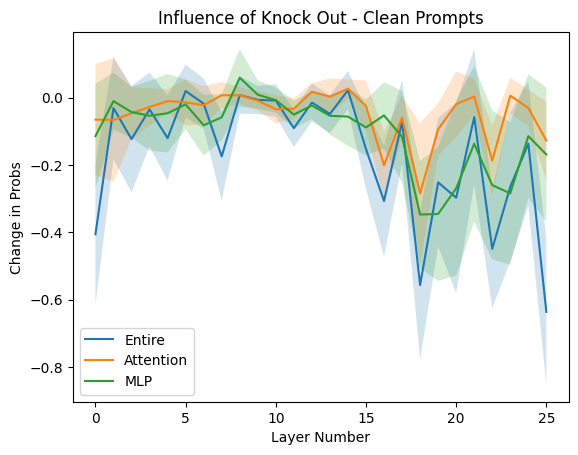

In [25]:
plot_list_of_list(
    data_sets=[Final_output["clean"]["entire"], Final_output["clean"]["attn"], Final_output["clean"]["mlp"]],
    label_sets=["Entire", "Attention", "MLP"],
    title="Clean Prompts"
)

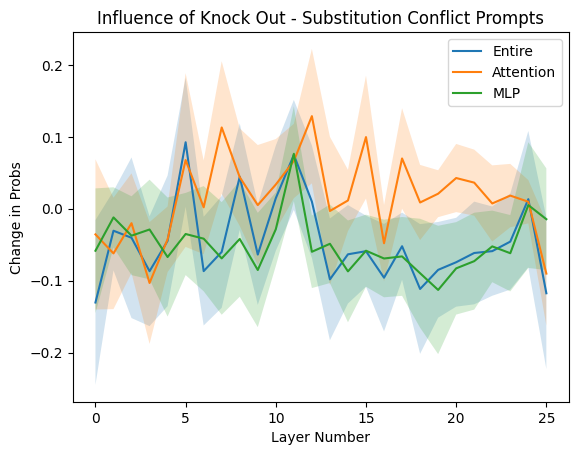

In [56]:
plot_list_of_list(
    data_sets=[Final_output["sub_conflict"]["entire"], Final_output["sub_conflict"]["attn"], Final_output["sub_conflict"]["mlp"]],
    label_sets=["Entire", "Attention", "MLP"],
    title="Substitution Conflict Prompts"
)

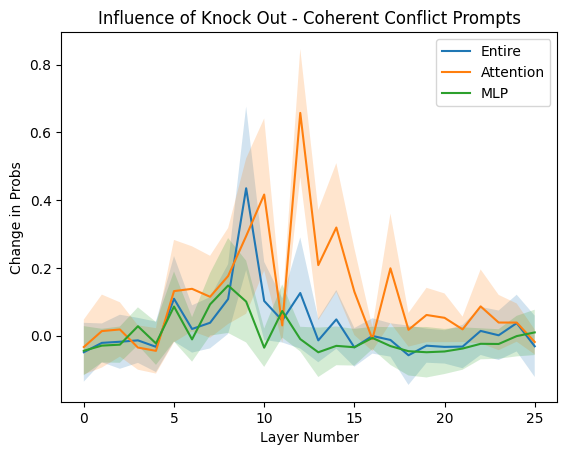

In [58]:
plot_list_of_list(
    data_sets=[Final_output["coh_conflict"]["entire"], Final_output["coh_conflict"]["attn"], Final_output["coh_conflict"]["mlp"]],
    label_sets=["Entire", "Attention", "MLP"],
    title="Coherent Conflict Prompts"
)

In [26]:
def plot_list_of_list_side_by_side(data_sets_list, label_sets_list, titles):
    """
    Plots multiple plots side by side horizontally, given multiple datasets and corresponding labels.

    :param data_sets_list: A list where each element is a list of data sets for a single subplot.
    :param label_sets_list: A list where each element is a list of labels corresponding to the datasets.
    :param titles: A list of titles for each subplot.
    """
    num_plots = len(data_sets_list)  # Number of subplots
    fig, axs = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))  # Create subplots

    for i, (data_sets, label_sets, title) in enumerate(zip(data_sets_list, label_sets_list, titles)):
        ax = axs[i] if num_plots > 1 else axs  # Handle single subplot case
        for data, label in zip(data_sets, label_sets):
            data_array = np.array(data)

            # Calculate the mean and std along the rows
            mean = np.mean(data_array, axis=0)
            std = np.std(data_array, axis=0)

            # Generate x values (assuming they're common across all lists)
            x_values = np.arange(len(mean))

            # Plot the mean line
            ax.plot(x_values, mean, label=label)

            # Fill between (mean - std) and (mean + std) to add the shading
            ax.fill_between(x_values, mean - std, mean + std, alpha=0.2)
        
        ax.set_xlabel('Layer Number', fontsize=16)
        ax.set_ylabel('Change in Probs', fontsize=16)
        ax.set_title(f'Influence of Knock Out - {title}', fontsize=18)
        ax.legend(fontsize=12)

        # Add labels, title, and a legend
        # ax.set_xlabel('Layer Number')
        # ax.set_ylabel('Change in Probs')
        # ax.set_title(f'Influence of Knock Out - {title}')
        # ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.savefig("/home/gaotang3/Knowledge_conflict_clean/result_processor/knock_out_notCompact.pdf")
    plt.show()

In [27]:
def plot_list_of_list_side_by_side(data_sets_list, label_sets_list, titles):
    num_plots = len(data_sets_list)
    fig, axs = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    # Calculate the global y-axis limits
    global_min = float('inf')
    global_max = float('-inf')
    for data_sets in data_sets_list:
        for data in data_sets:
            data_array = np.array(data)
            global_min = min(global_min, np.min(data_array))
            global_max = max(global_max, np.max(data_array))

    # Add some padding for visual clarity
    y_padding = 0.05 * (global_max - global_min)
    global_min -= y_padding
    global_max += y_padding

    # Plot each subplot with shared y-axis limits
    for i, (data_sets, label_sets, title) in enumerate(zip(data_sets_list, label_sets_list, titles)):
        ax = axs[i] if num_plots > 1 else axs
        for data, label in zip(data_sets, label_sets):
            data_array = np.array(data)
            mean = np.mean(data_array, axis=0)
            std = np.std(data_array, axis=0)
            x_values = np.arange(len(mean))
            ax.plot(x_values, mean, label=label)
            ax.fill_between(x_values, mean - std, mean + std, alpha=0.2)

        # Set the same y-axis limits for all subplots
        ax.set_ylim(global_min, global_max)

        # Add labels, title, and legend
        ax.set_xlabel('Layer Number', fontsize=16)
        ax.set_ylabel('Change in Probs', fontsize=16)
        ax.set_title(f'Influence of Knock Out - {title}', fontsize=18)
        ax.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig("/home/gaotang3/Knowledge_conflict_clean/result_processor/knock_out.pdf")
    plt.show()

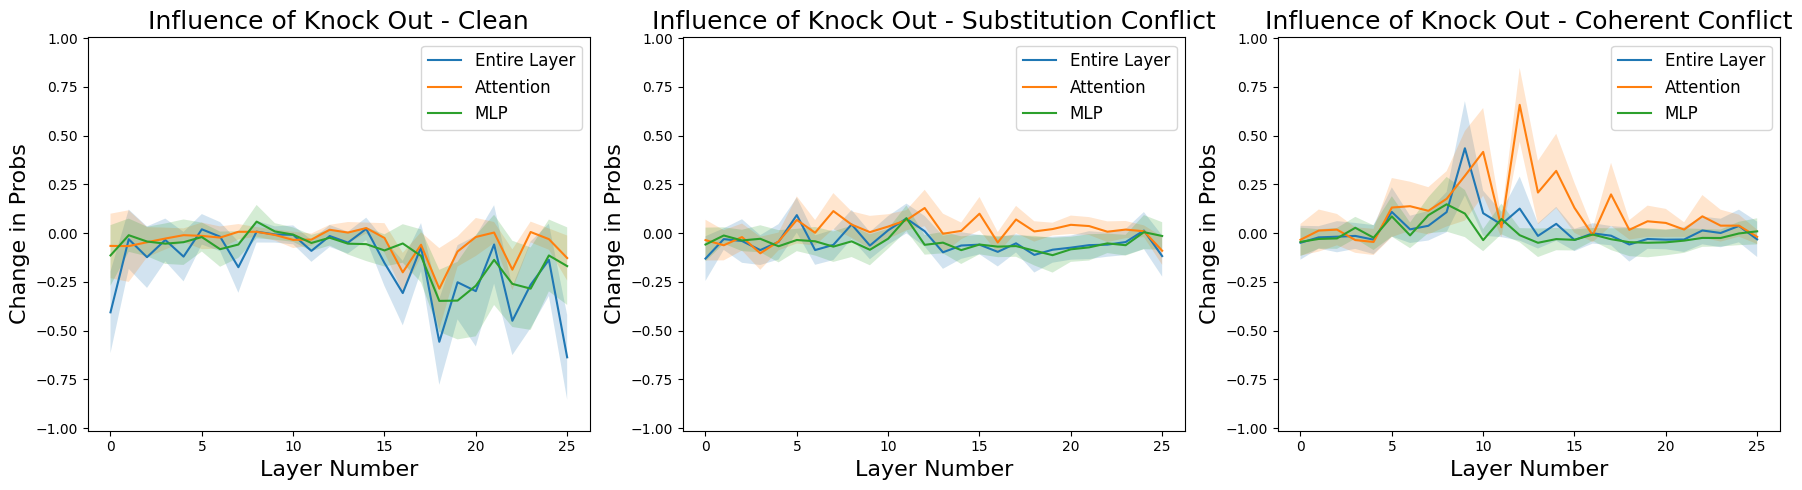

In [61]:
data_sets_list = [
    [Final_output["clean"]["entire"], Final_output["clean"]["attn"], Final_output["clean"]["mlp"]],
    [Final_output["sub_conflict"]["entire"], Final_output["sub_conflict"]["attn"], Final_output["sub_conflict"]["mlp"]],
    [Final_output["coh_conflict"]["entire"], Final_output["coh_conflict"]["attn"], Final_output["coh_conflict"]["mlp"]]
]
label_sets_list = [["Entire Layer", "Attention", "MLP"], ["Entire Layer", "Attention", "MLP"], ["Entire Layer", "Attention", "MLP"]]
titles = ["Clean", "Substitution Conflict", "Coherent Conflict"]
plot_list_of_list_side_by_side(data_sets_list, label_sets_list, titles)

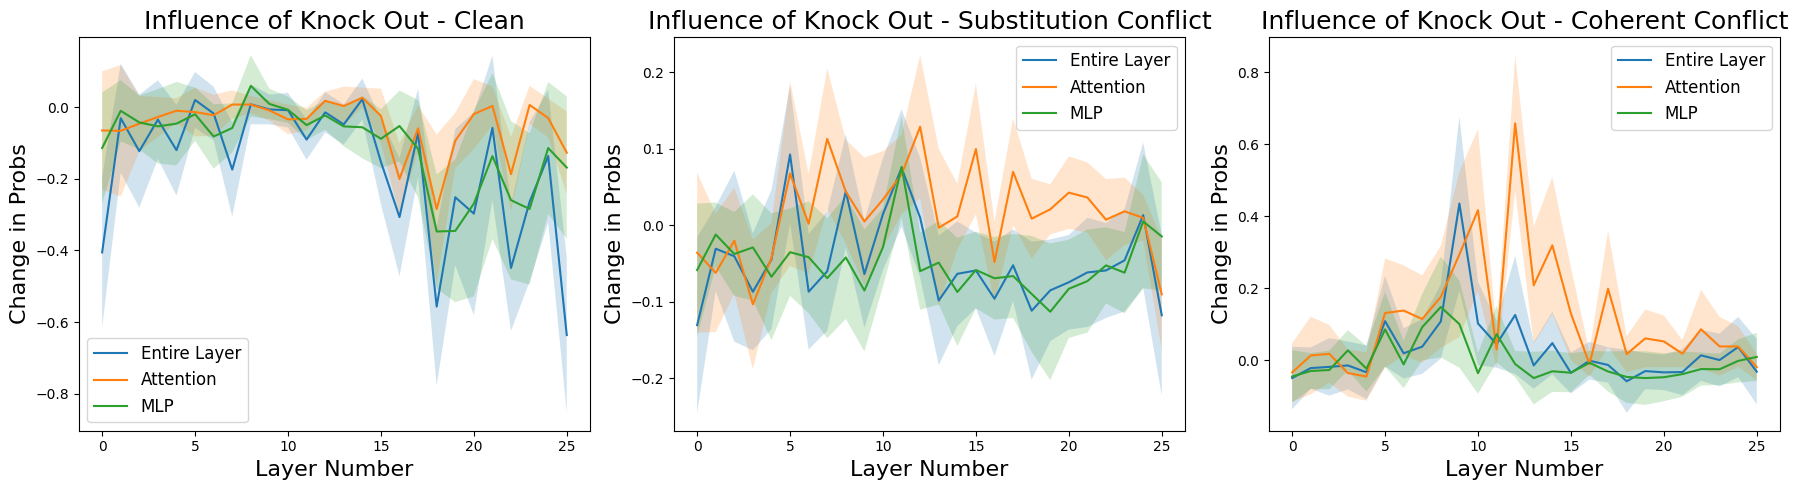

In [64]:
data_sets_list = [
    [Final_output["clean"]["entire"], Final_output["clean"]["attn"], Final_output["clean"]["mlp"]],
    [Final_output["sub_conflict"]["entire"], Final_output["sub_conflict"]["attn"], Final_output["sub_conflict"]["mlp"]],
    [Final_output["coh_conflict"]["entire"], Final_output["coh_conflict"]["attn"], Final_output["coh_conflict"]["mlp"]]
]
label_sets_list = [["Entire Layer", "Attention", "MLP"], ["Entire Layer", "Attention", "MLP"], ["Entire Layer", "Attention", "MLP"]]
titles = ["Clean", "Substitution Conflict", "Coherent Conflict"]

plot_list_of_list_side_by_side(data_sets_list, label_sets_list, titles)